In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 500
beta = torch.linspace(0.004, 0.03, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0002, device='cuda:0')

In [3]:
alpha_

tensor([9.9600e-01, 9.9196e-01, 9.8789e-01, 9.8379e-01, 9.7965e-01, 9.7547e-01,
        9.7127e-01, 9.6703e-01, 9.6276e-01, 9.5845e-01, 9.5412e-01, 9.4976e-01,
        9.4536e-01, 9.4094e-01, 9.3649e-01, 9.3201e-01, 9.2751e-01, 9.2298e-01,
        9.1842e-01, 9.1384e-01, 9.0923e-01, 9.0460e-01, 8.9994e-01, 8.9526e-01,
        8.9056e-01, 8.8584e-01, 8.8110e-01, 8.7633e-01, 8.7155e-01, 8.6675e-01,
        8.6192e-01, 8.5708e-01, 8.5223e-01, 8.4735e-01, 8.4246e-01, 8.3756e-01,
        8.3264e-01, 8.2770e-01, 8.2275e-01, 8.1779e-01, 8.1281e-01, 8.0782e-01,
        8.0282e-01, 7.9781e-01, 7.9279e-01, 7.8776e-01, 7.8273e-01, 7.7768e-01,
        7.7262e-01, 7.6756e-01, 7.6249e-01, 7.5741e-01, 7.5233e-01, 7.4724e-01,
        7.4215e-01, 7.3706e-01, 7.3196e-01, 7.2686e-01, 7.2175e-01, 7.1665e-01,
        7.1154e-01, 7.0643e-01, 7.0132e-01, 6.9622e-01, 6.9111e-01, 6.8601e-01,
        6.8090e-01, 6.7580e-01, 6.7070e-01, 6.6561e-01, 6.6052e-01, 6.5543e-01,
        6.5035e-01, 6.4528e-01, 6.4021e-

torch.Size([4, 3, 72, 72])


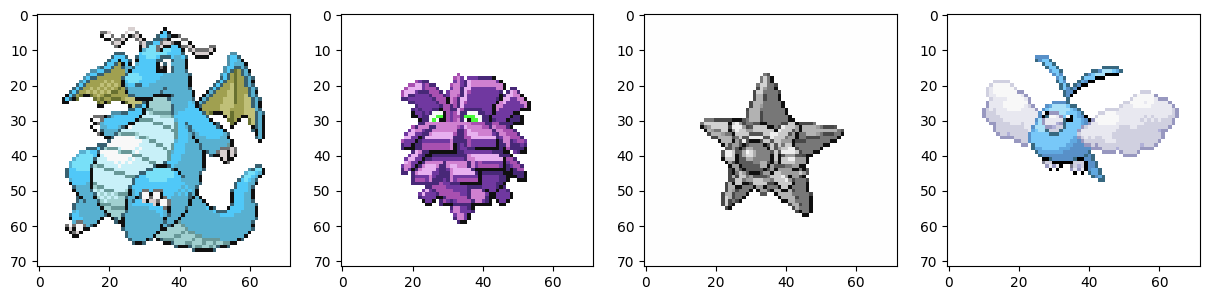

In [4]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #Sobel(),

])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], .3),
    v2.RandomApply([v2.RandomChannelPermutation()], .3),
    v2.RandomGrayscale(p = .3),
])

source = torch.randint(0, 2, (4,))
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
print(x0.shape)


fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
@torch.no_grad
def generate_image():
    global model
    model.eval()

    N = 3
    
    #A = torch.tensor([300, 300, 300], device=device)
    #x0 = pimages[1, [0,151,251]]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    #x0 = isigmoid(x0)
    #z = torch.randn_like(x0)
    #x = torch.sqrt(alpha_[A])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[A])[:, None, None, None] * z

    x = torch.randn((N, 3, 72, 72), device=device)
    
    ty = [["Grass"], ["Fire"], ["Water"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    c = contour[0, [0, 151, 251]]
    c = torch.stack([pos_transform(d) for d in c], dim=0)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty, c) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x-e)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

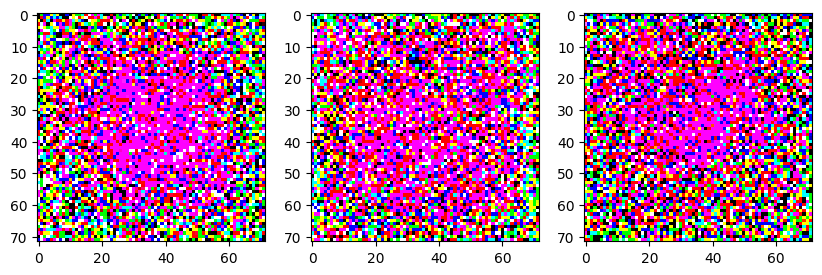

0.04455801:   1%|          | 1000/100001 [00:43<1:06:43, 24.73it/s]

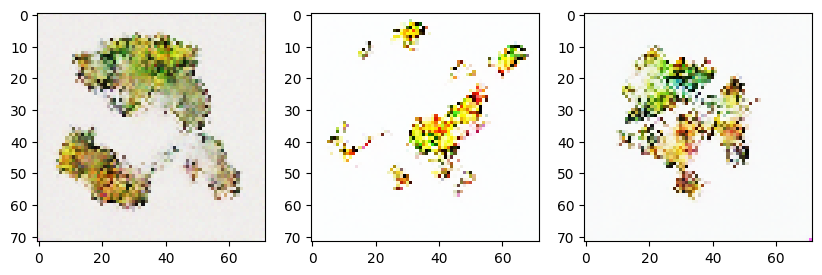

0.03370222:   2%|▏         | 1999/100001 [01:26<1:06:04, 24.72it/s]

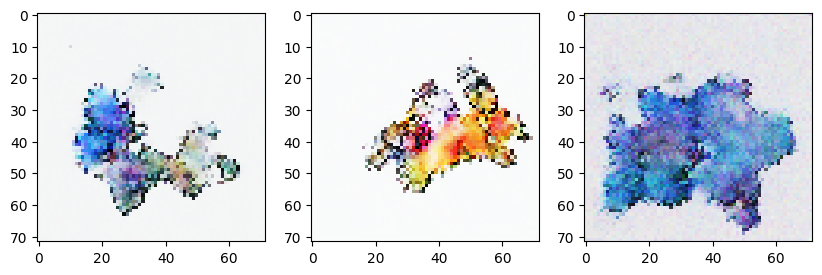

0.04960480:   3%|▎         | 2998/100001 [02:09<1:05:26, 24.70it/s]

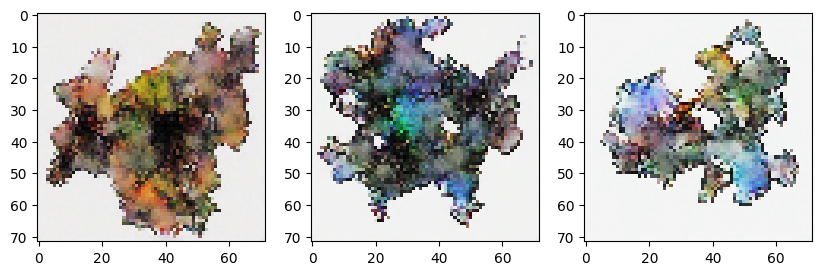

0.05595913:   4%|▍         | 4000/100001 [02:52<1:04:42, 24.73it/s]

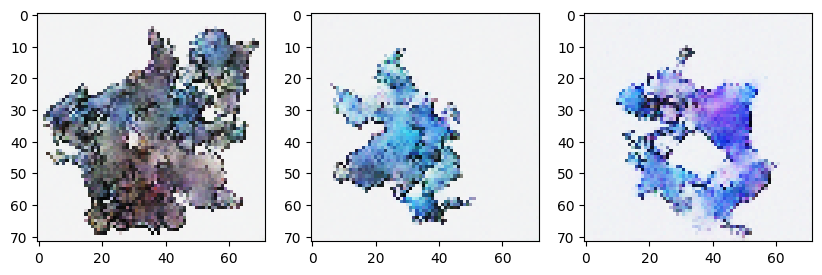

0.03715412:   5%|▍         | 4999/100001 [03:34<1:04:05, 24.70it/s]

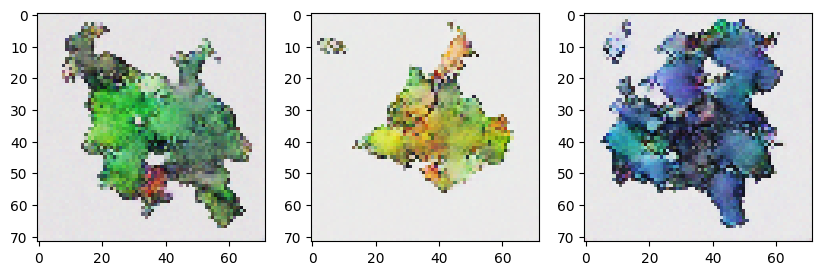

0.02695200:   6%|▌         | 5998/100001 [04:17<1:03:31, 24.66it/s]

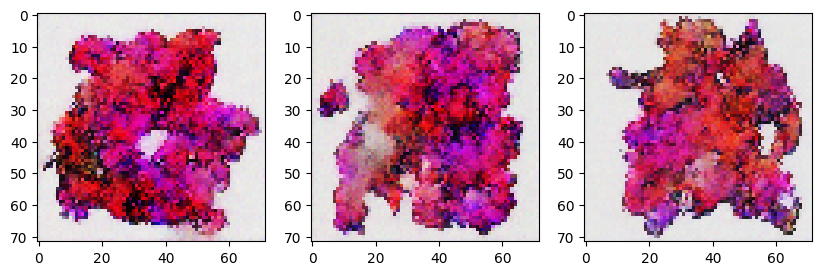

0.02592859:   7%|▋         | 7000/100001 [05:00<1:02:48, 24.68it/s]

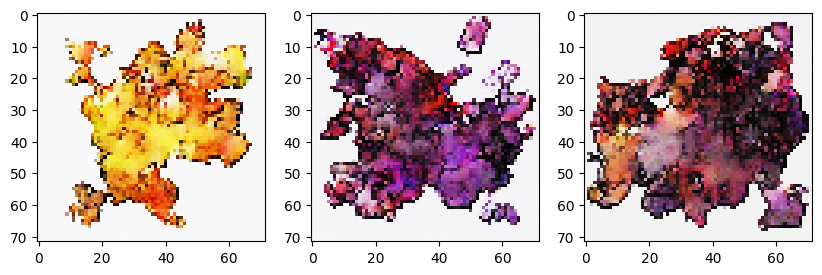

0.03932481:   8%|▊         | 7999/100001 [05:43<1:02:07, 24.68it/s]

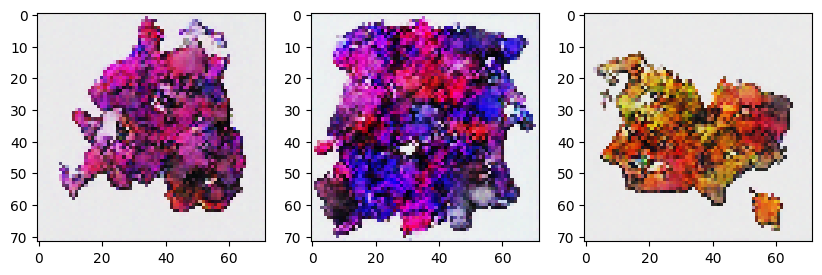

0.03763133:   9%|▉         | 8998/100001 [06:26<1:01:20, 24.73it/s]

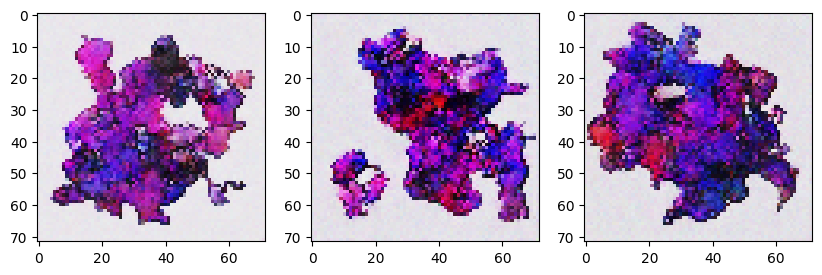

0.02161160:  10%|▉         | 10000/100001 [07:09<1:00:44, 24.70it/s]

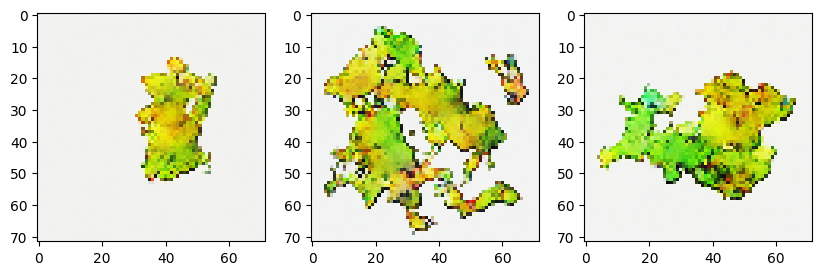

0.03487378:  11%|█         | 10999/100001 [07:52<59:54, 24.76it/s]  

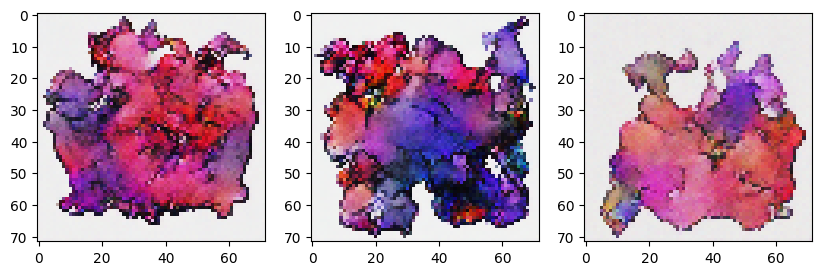

0.04785739:  12%|█▏        | 11998/100001 [08:35<59:21, 24.71it/s]  

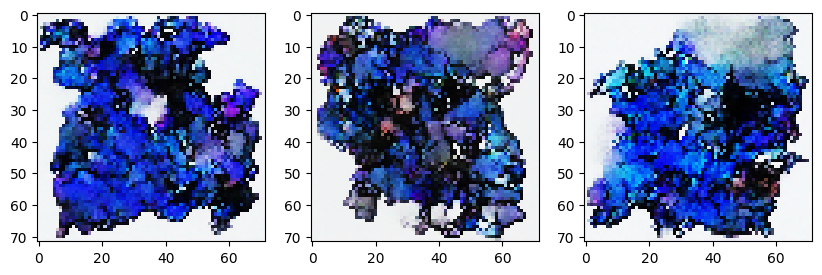

0.02474212:  13%|█▎        | 13000/100001 [09:18<58:42, 24.70it/s]  

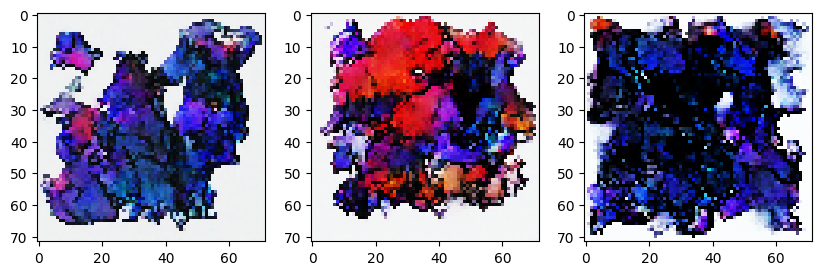

0.05088564:  14%|█▍        | 13999/100001 [10:01<57:52, 24.77it/s]  

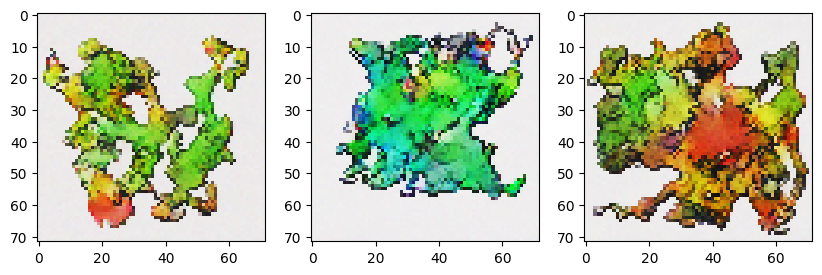

0.02662862:  15%|█▍        | 14998/100001 [10:43<57:04, 24.82it/s]  

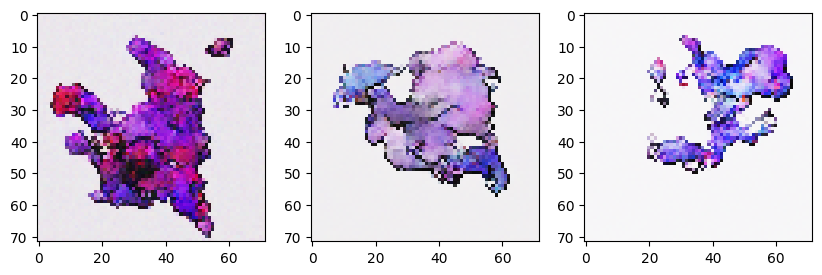

0.04102904:  16%|█▌        | 16000/100001 [11:26<56:32, 24.76it/s]  

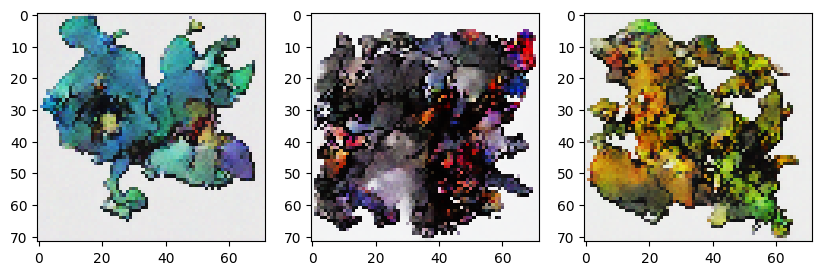

0.02881764:  17%|█▋        | 16999/100001 [12:09<55:53, 24.75it/s]  

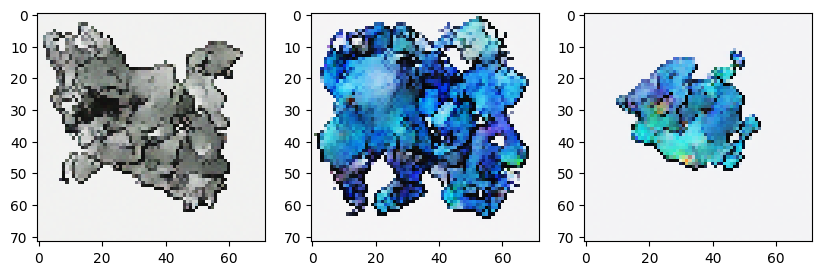

0.03638773:  18%|█▊        | 17998/100001 [12:52<55:11, 24.76it/s]  

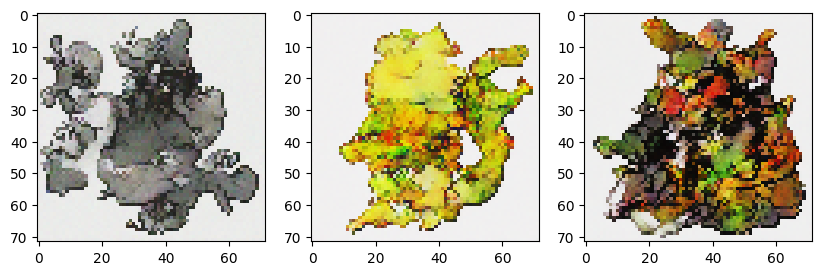

0.02604053:  19%|█▉        | 19000/100001 [13:35<54:42, 24.67it/s]  

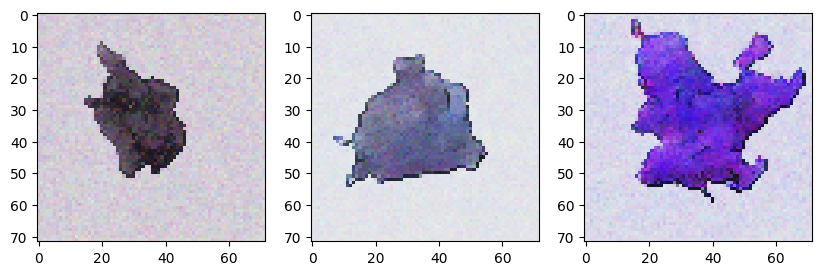

0.02283715:  20%|█▉        | 19999/100001 [14:18<53:40, 24.84it/s]  

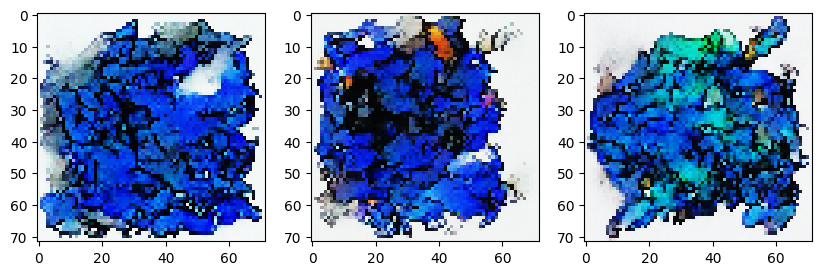

0.02147975:  21%|██        | 20998/100001 [15:01<53:12, 24.75it/s]  

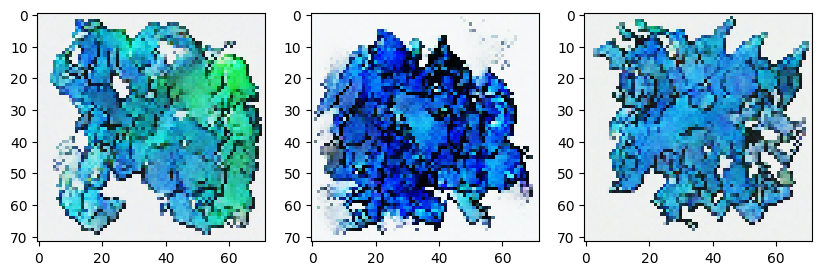

0.02652606:  22%|██▏       | 22000/100001 [15:44<52:41, 24.67it/s]  

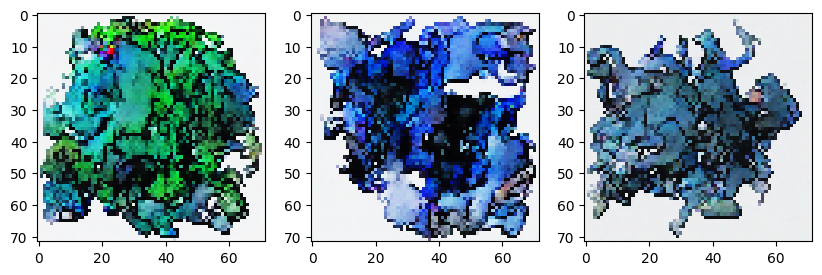

0.05650458:  23%|██▎       | 22999/100001 [16:26<51:57, 24.70it/s]  

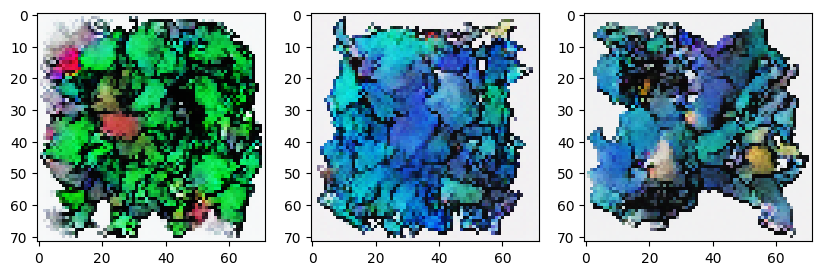

0.04173736:  24%|██▍       | 23998/100001 [17:09<51:16, 24.70it/s]  

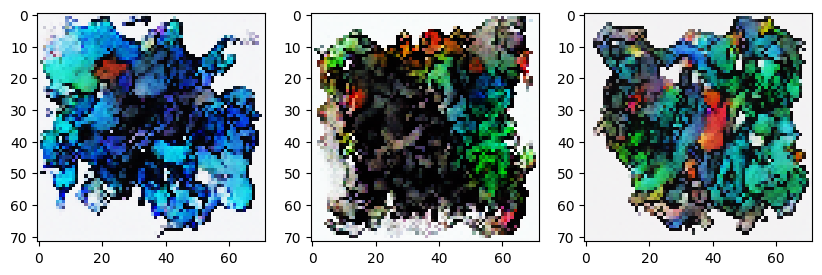

0.02476124:  25%|██▍       | 25000/100001 [17:52<50:44, 24.63it/s]  

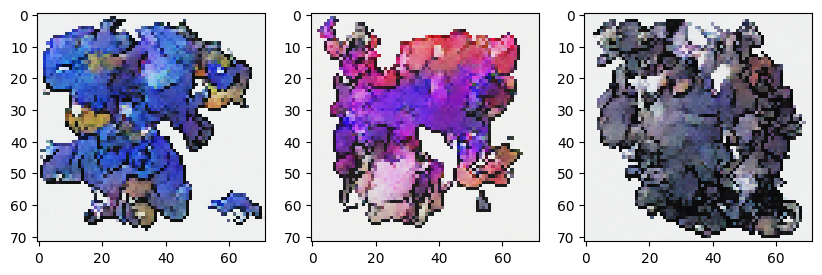

0.01869906:  26%|██▌       | 25999/100001 [18:35<49:54, 24.71it/s]  

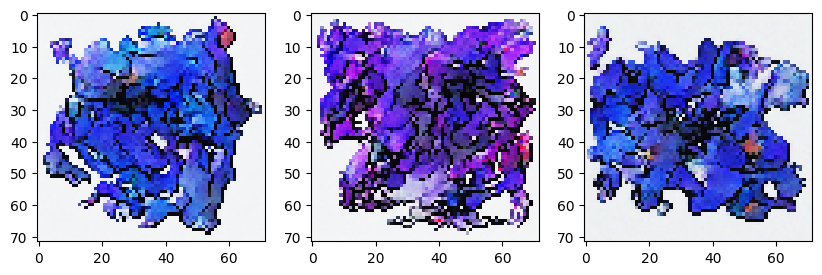

0.03217616:  27%|██▋       | 26998/100001 [19:18<49:07, 24.77it/s]  

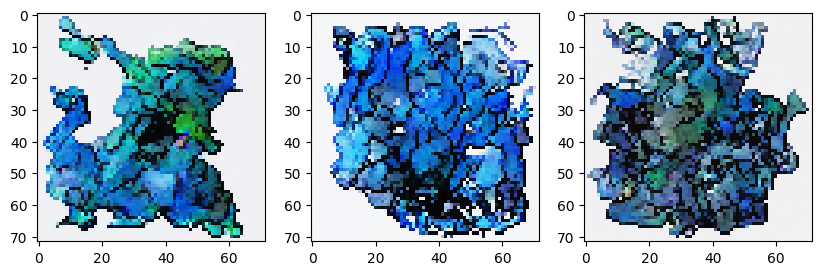

0.02868260:  28%|██▊       | 28000/100001 [20:01<48:35, 24.69it/s]  

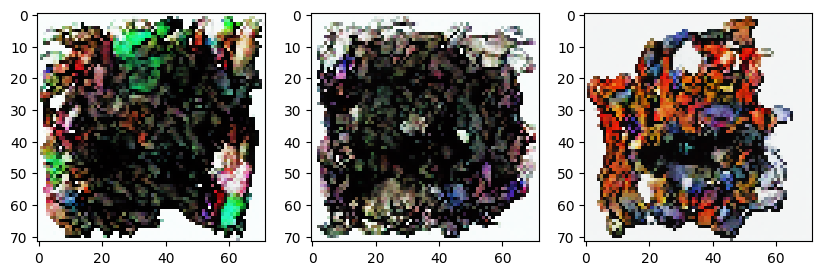

0.02812605:  29%|██▉       | 28999/100001 [20:44<47:56, 24.68it/s]  

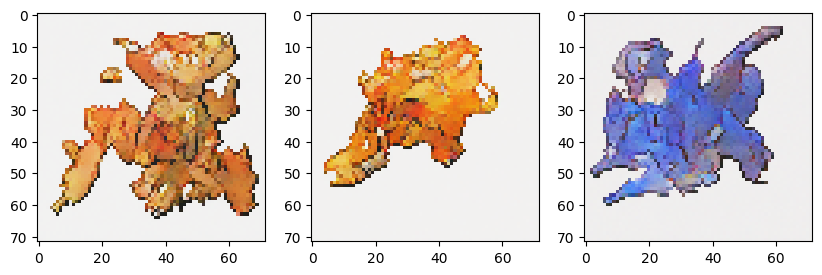

0.02683070:  30%|██▉       | 29998/100001 [21:27<47:13, 24.70it/s]  

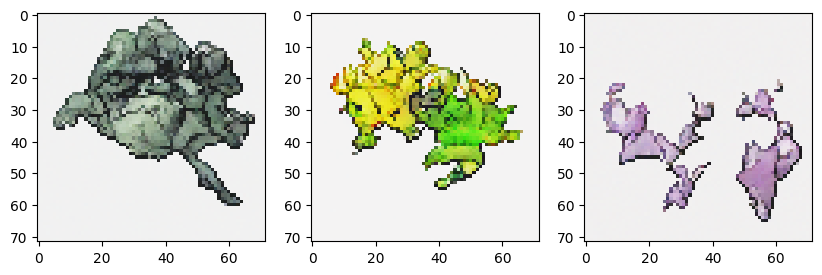

0.03916399:  31%|███       | 31000/100001 [22:10<46:32, 24.71it/s]  

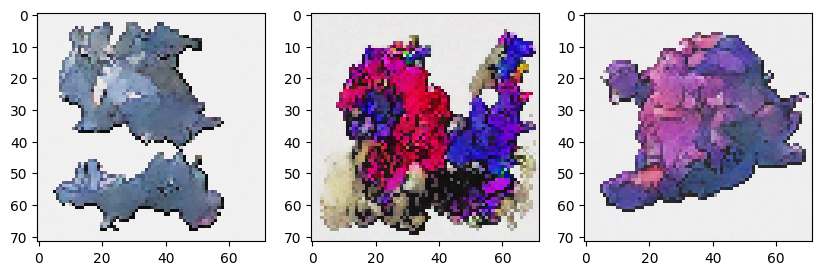

0.02484898:  32%|███▏      | 31999/100001 [22:53<45:47, 24.75it/s]  

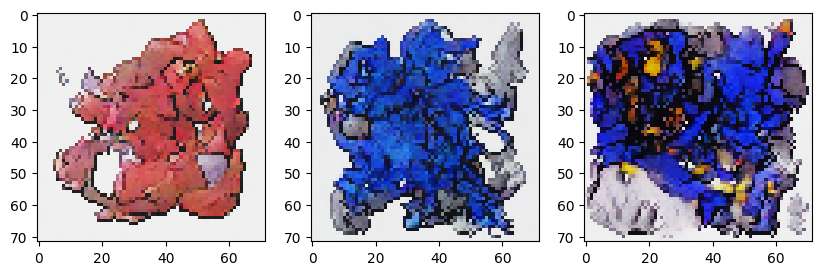

0.02405749:  33%|███▎      | 32998/100001 [23:36<45:07, 24.75it/s]  

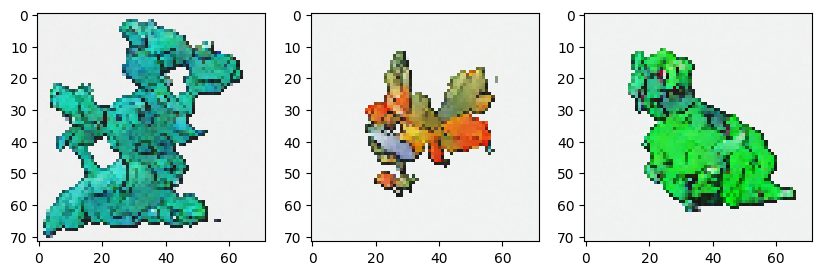

0.02676438:  34%|███▍      | 34000/100001 [24:19<44:32, 24.70it/s]  

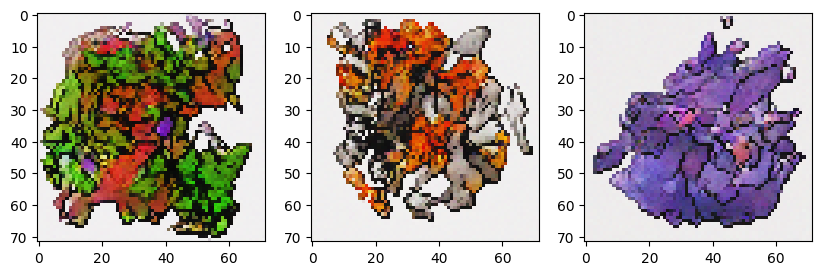

0.02480149:  35%|███▍      | 34999/100001 [25:02<43:44, 24.77it/s]  

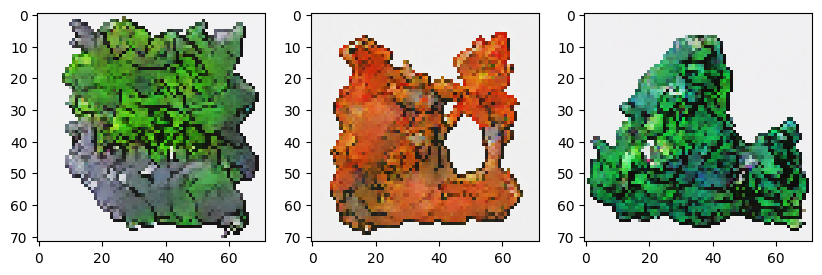

0.02298716:  36%|███▌      | 35998/100001 [25:44<43:09, 24.72it/s]  

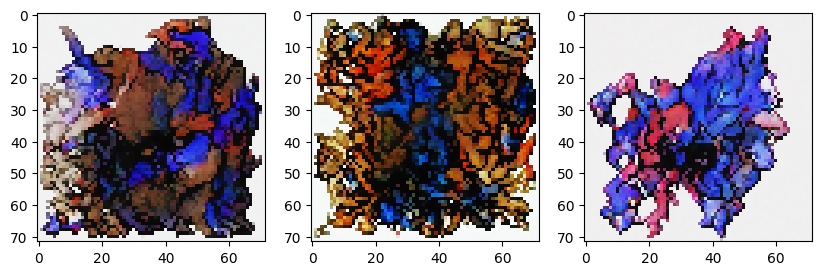

0.02488609:  37%|███▋      | 37000/100001 [26:27<42:34, 24.66it/s]  

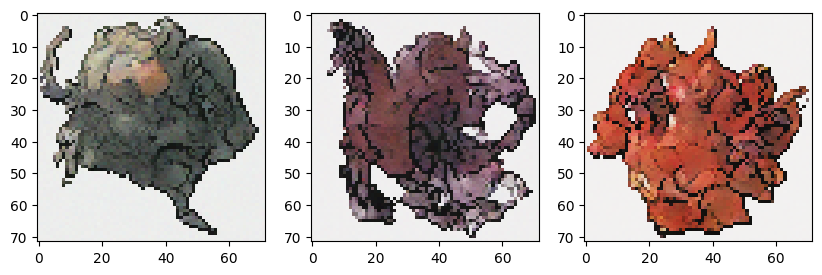

0.02079311:  38%|███▊      | 37999/100001 [27:10<41:51, 24.69it/s]  

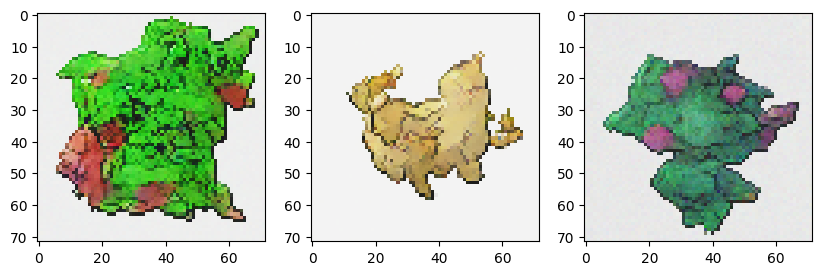

0.02538345:  39%|███▉      | 38998/100001 [27:53<41:21, 24.58it/s]  

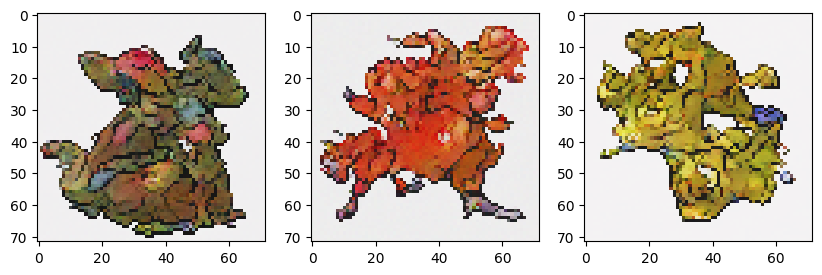

0.02323300:  40%|███▉      | 40000/100001 [28:36<40:27, 24.72it/s]  

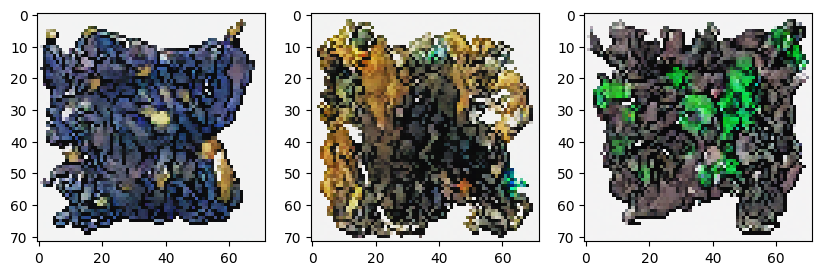

0.02947192:  41%|████      | 40999/100001 [29:19<39:49, 24.69it/s]  

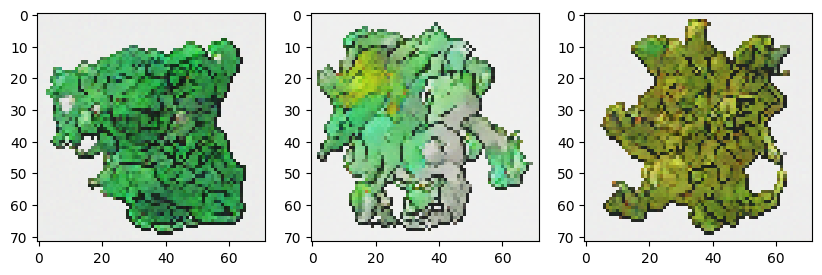

0.02309174:  42%|████▏     | 41998/100001 [30:02<39:02, 24.76it/s]  

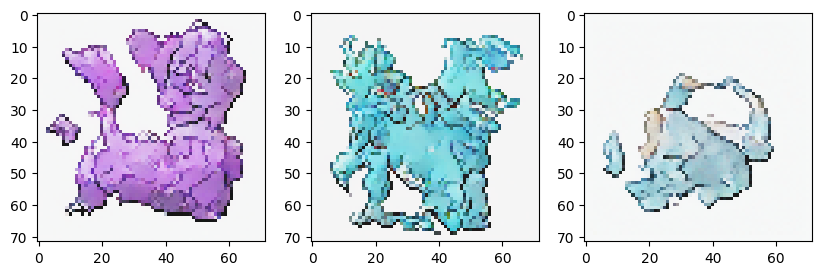

0.02551052:  43%|████▎     | 43000/100001 [30:45<38:38, 24.58it/s]  

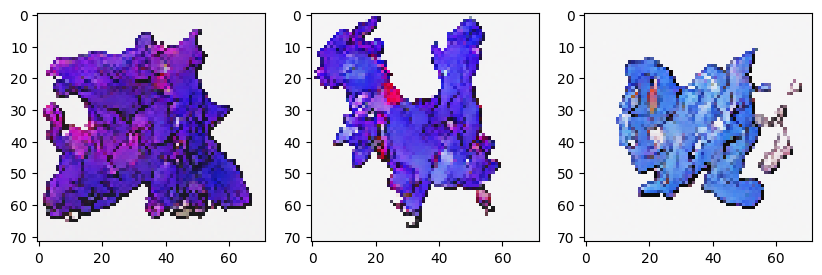

0.01137403:  44%|████▍     | 43999/100001 [31:28<37:47, 24.69it/s]  

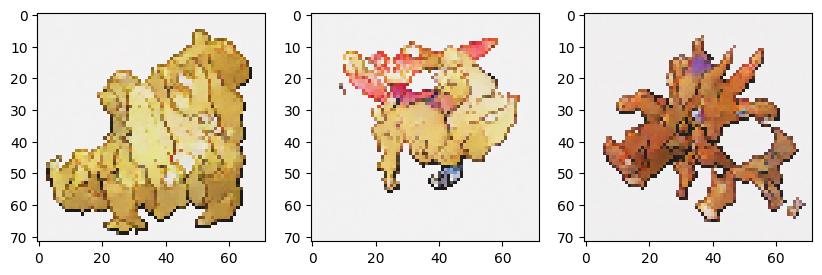

0.01052381:  45%|████▍     | 44998/100001 [32:11<36:55, 24.83it/s]  

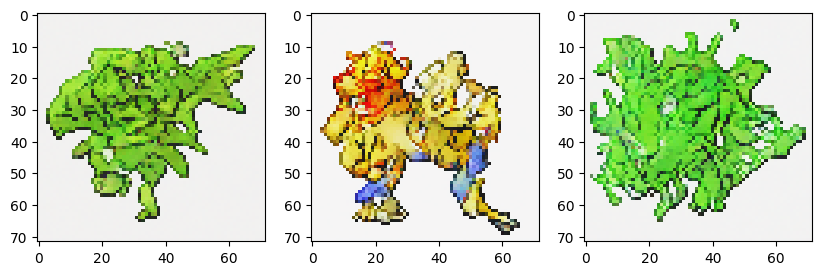

0.01856073:  46%|████▌     | 46000/100001 [32:54<36:16, 24.81it/s]  

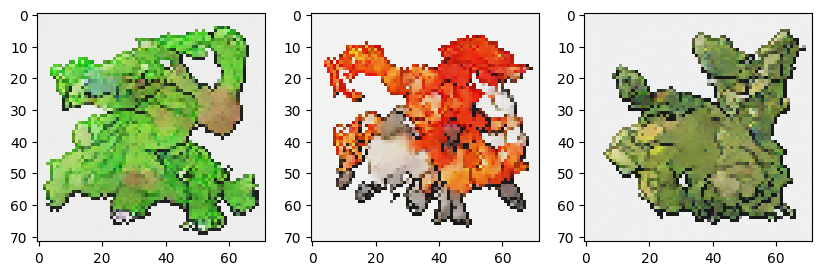

0.03321607:  47%|████▋     | 46999/100001 [33:36<35:40, 24.76it/s]  

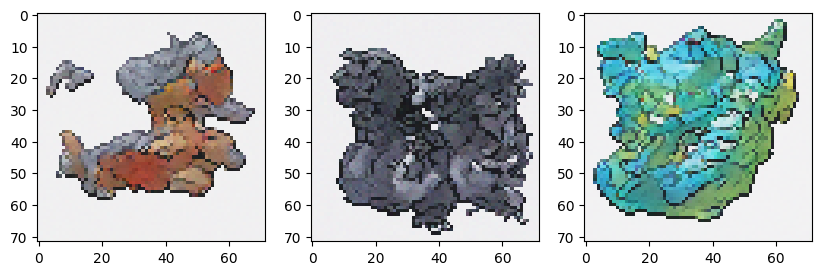

0.02221585:  48%|████▊     | 47998/100001 [34:19<34:50, 24.88it/s]  

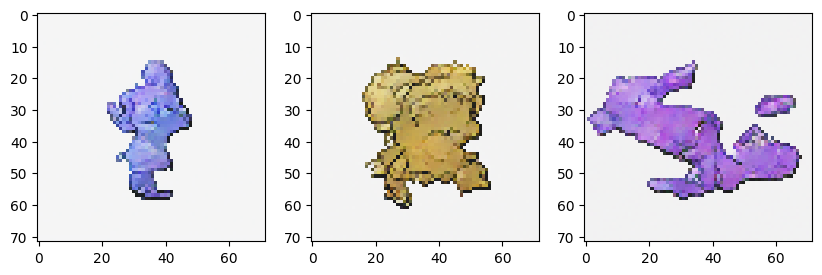

0.02379526:  49%|████▉     | 49000/100001 [35:02<34:25, 24.69it/s]  

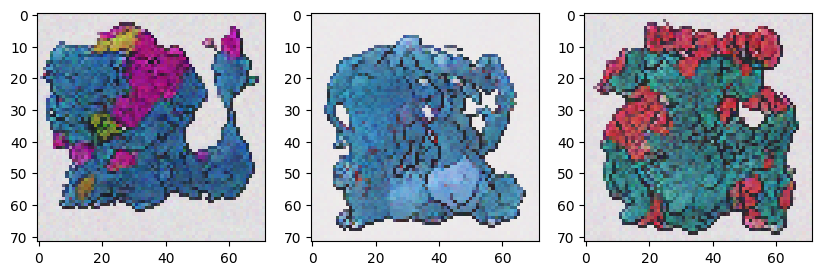

0.03236277:  50%|████▉     | 49999/100001 [35:45<33:43, 24.71it/s]  

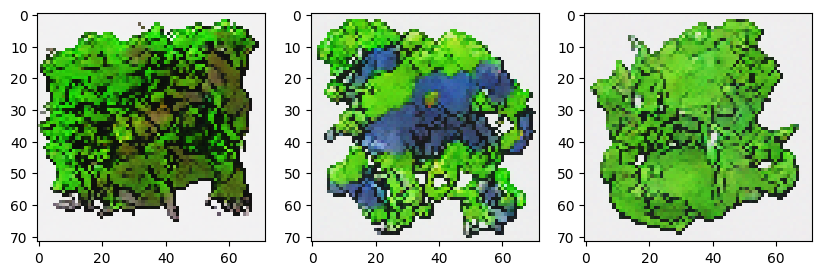

0.02893142:  51%|█████     | 50998/100001 [36:28<33:05, 24.68it/s]  

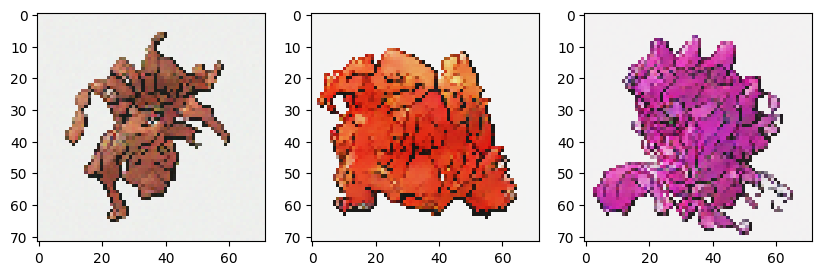

0.02319119:  52%|█████▏    | 52000/100001 [37:11<32:20, 24.73it/s]  

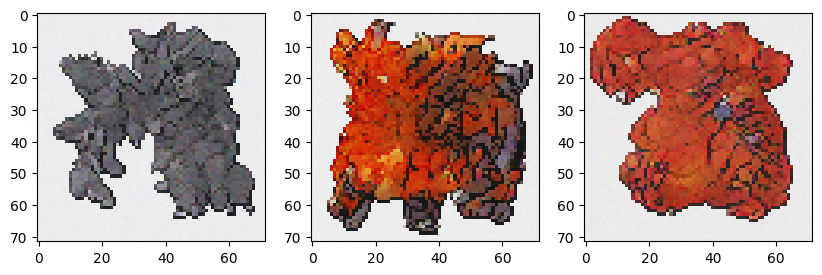

0.02172149:  53%|█████▎    | 52999/100001 [37:54<31:39, 24.75it/s]  

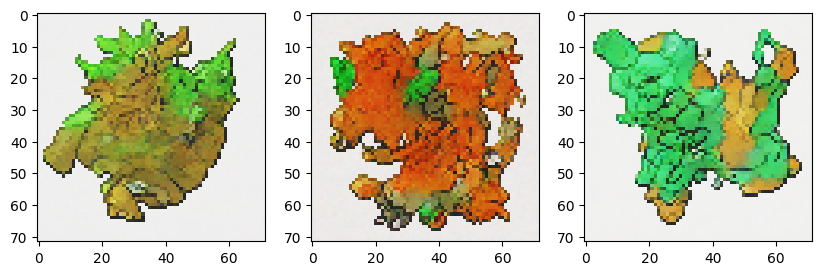

0.02048670:  54%|█████▍    | 53998/100001 [38:37<31:01, 24.71it/s]  

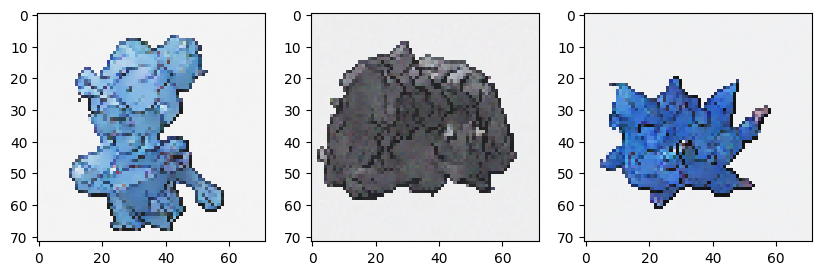

0.03484664:  55%|█████▍    | 55000/100001 [39:20<30:23, 24.68it/s]  

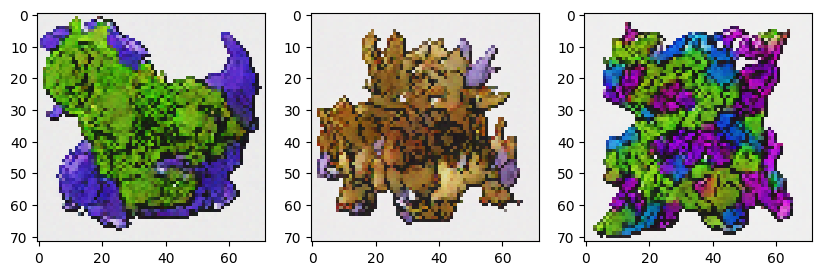

0.01760942:  56%|█████▌    | 55999/100001 [40:03<29:37, 24.75it/s]  

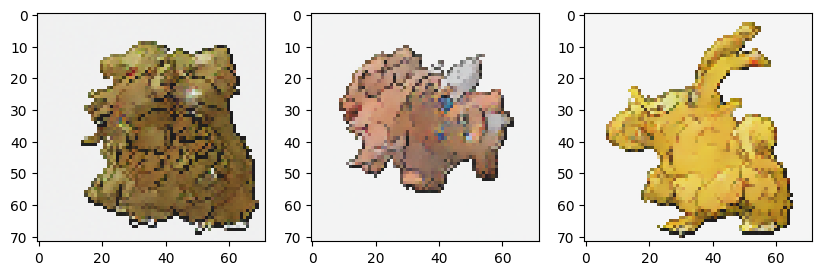

0.01793668:  57%|█████▋    | 56998/100001 [40:45<29:04, 24.65it/s]  

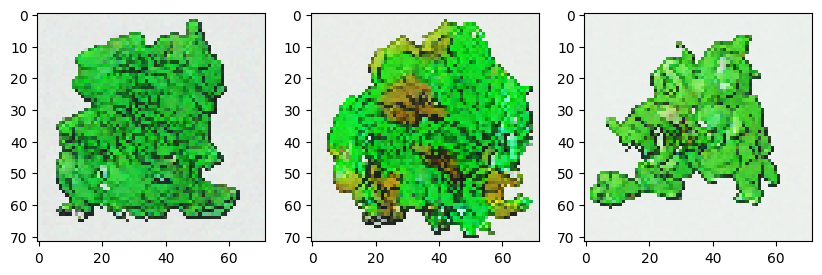

0.01435767:  58%|█████▊    | 58000/100001 [41:28<28:24, 24.64it/s]  

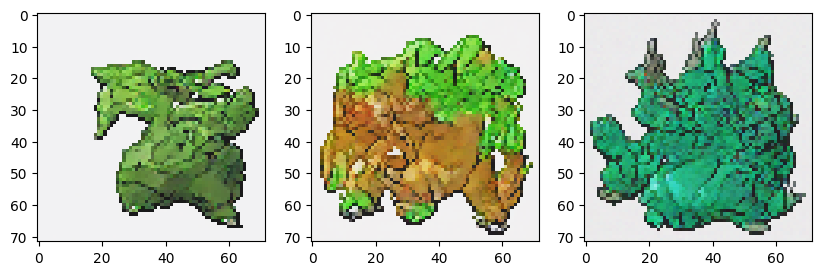

0.01954493:  59%|█████▉    | 58999/100001 [42:11<27:42, 24.67it/s]  

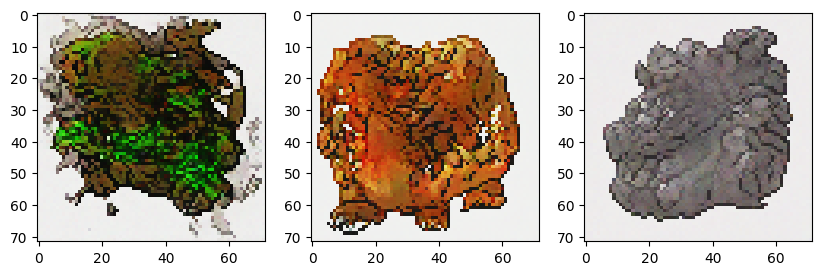

0.01415003:  60%|█████▉    | 59998/100001 [42:54<26:56, 24.75it/s]  

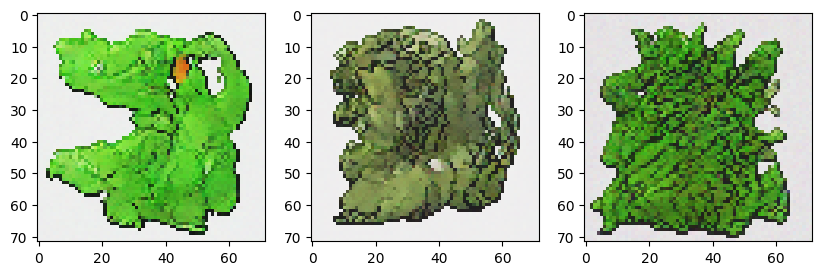

0.02837468:  61%|██████    | 61000/100001 [43:37<26:16, 24.74it/s]  

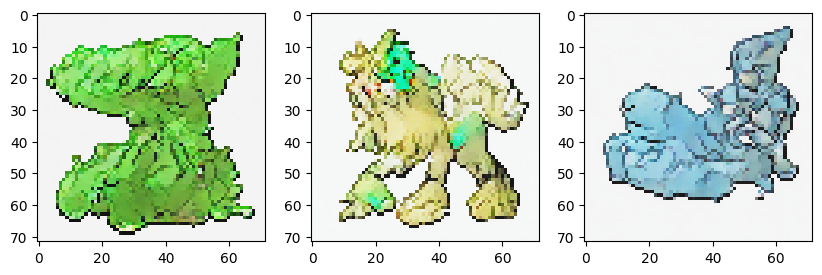

0.01670920:  62%|██████▏   | 61999/100001 [44:20<25:34, 24.76it/s]  

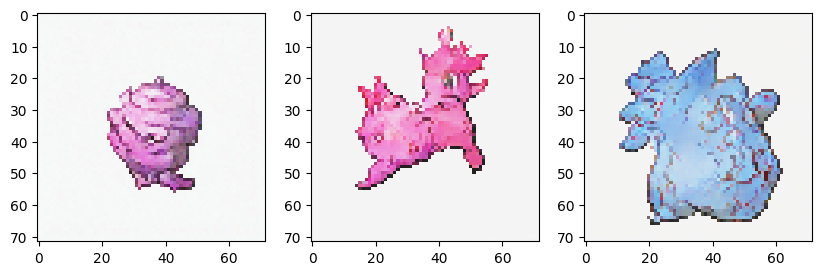

0.00741850:  63%|██████▎   | 62998/100001 [45:03<24:57, 24.71it/s]  

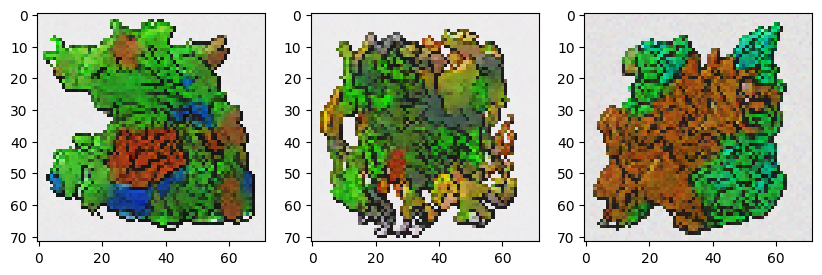

0.01529493:  64%|██████▍   | 64000/100001 [45:46<24:16, 24.72it/s]  

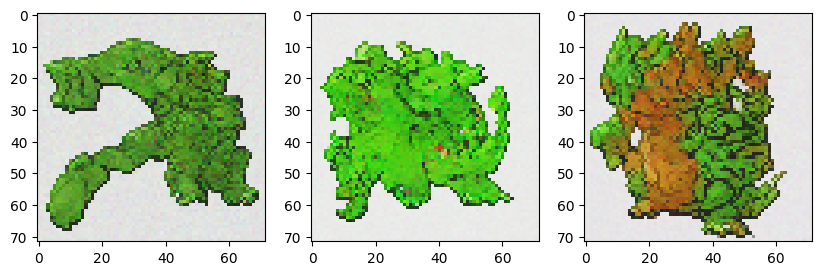

0.01350685:  65%|██████▍   | 64999/100001 [46:29<23:38, 24.68it/s]  

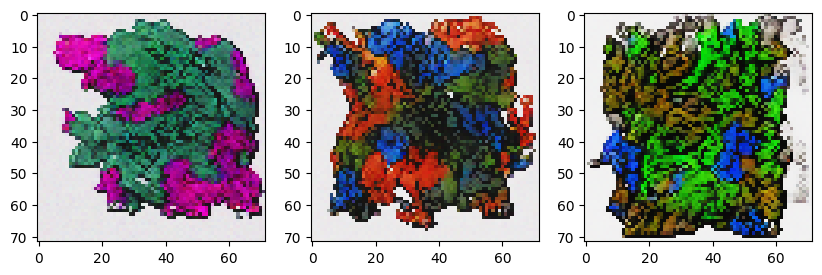

0.01966693:  66%|██████▌   | 65998/100001 [47:12<22:58, 24.68it/s]  

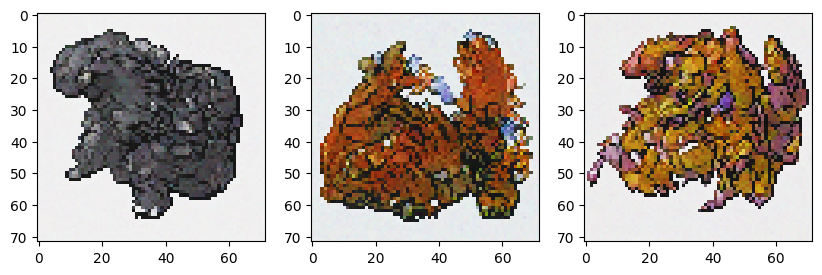

0.01827791:  67%|██████▋   | 67000/100001 [47:55<22:15, 24.71it/s]  

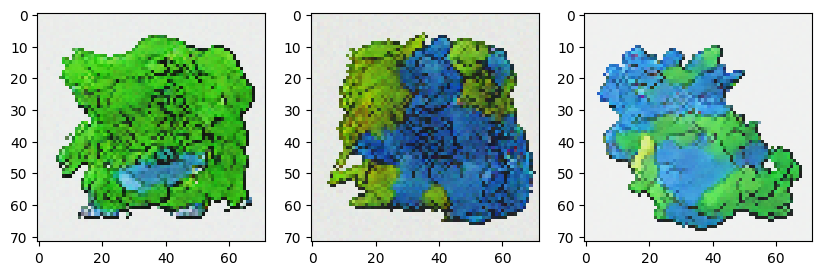

0.02597379:  68%|██████▊   | 67999/100001 [48:37<21:34, 24.72it/s]  

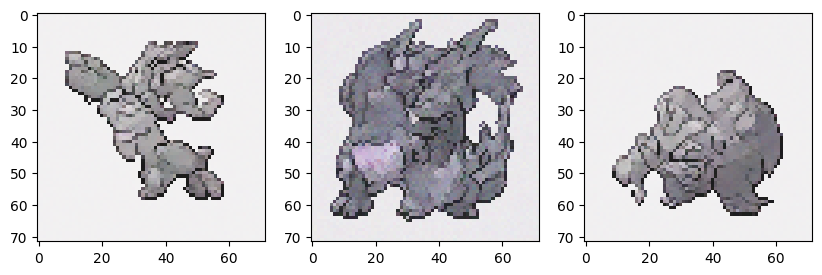

0.01551287:  69%|██████▉   | 68998/100001 [49:20<20:55, 24.70it/s]  

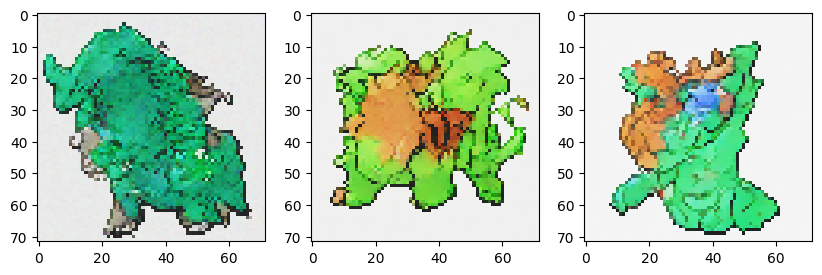

0.01587377:  70%|██████▉   | 70000/100001 [50:03<20:14, 24.70it/s]  

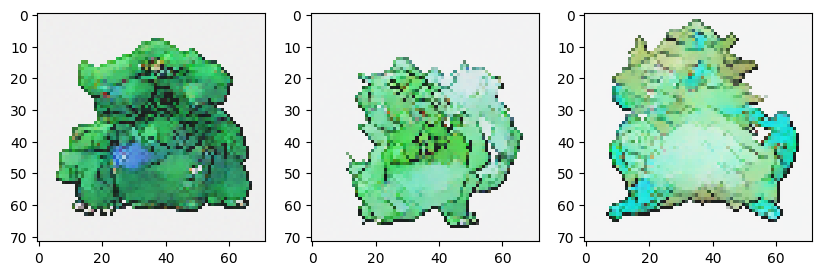

0.01643586:  71%|███████   | 70999/100001 [50:46<19:31, 24.77it/s]  

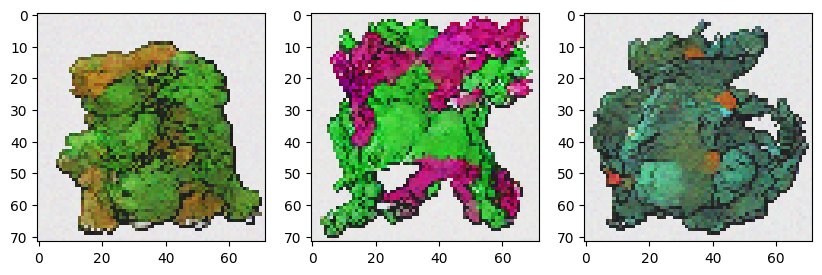

0.02914559:  72%|███████▏  | 71998/100001 [51:29<18:51, 24.74it/s]  

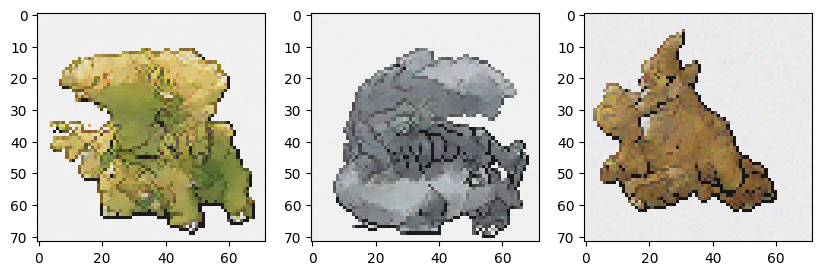

0.02781336:  73%|███████▎  | 73000/100001 [52:12<18:13, 24.70it/s]  

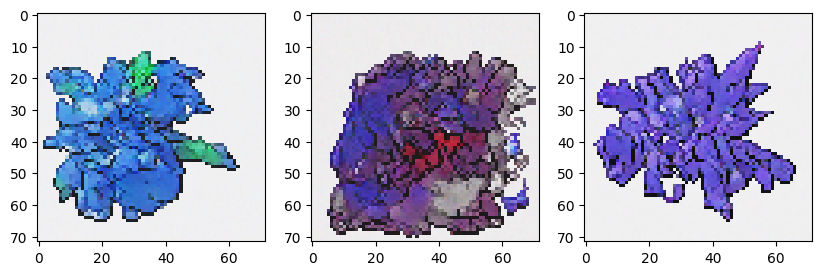

0.01946740:  74%|███████▍  | 73999/100001 [52:55<17:26, 24.85it/s]  

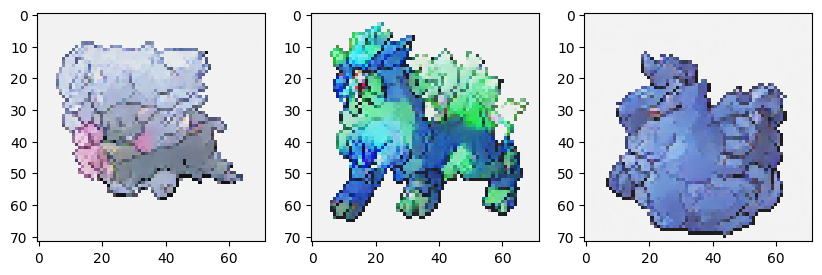

0.01657317:  75%|███████▍  | 74998/100001 [53:38<16:52, 24.68it/s]  

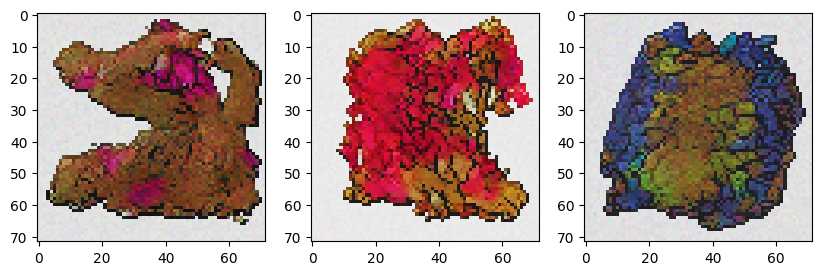

0.02552911:  76%|███████▌  | 76000/100001 [54:21<16:14, 24.63it/s]  

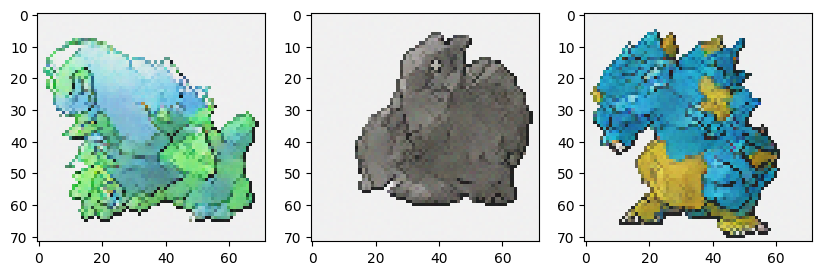

0.01806919:  77%|███████▋  | 76999/100001 [55:04<15:28, 24.77it/s]  

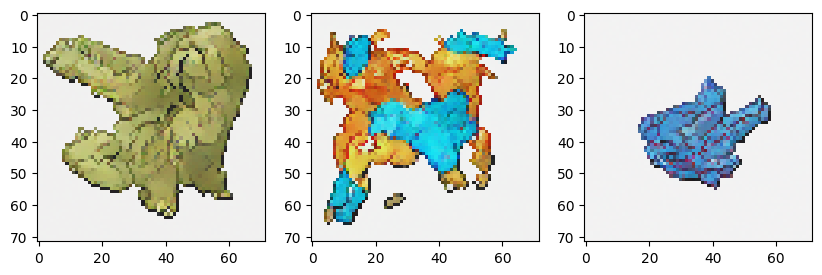

0.02061452:  78%|███████▊  | 77998/100001 [55:46<14:49, 24.74it/s]  

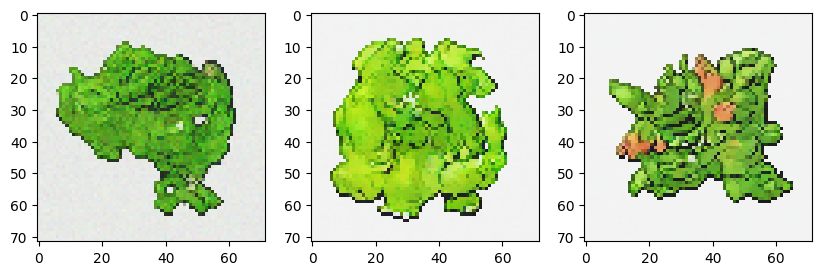

0.01635771:  79%|███████▉  | 79000/100001 [56:29<14:08, 24.75it/s]  

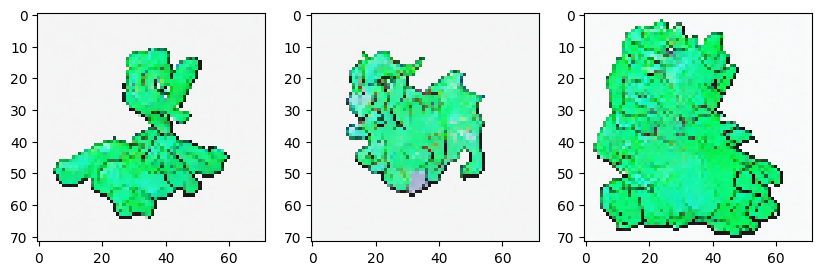

0.02121373:  80%|███████▉  | 79999/100001 [57:12<13:28, 24.75it/s]  

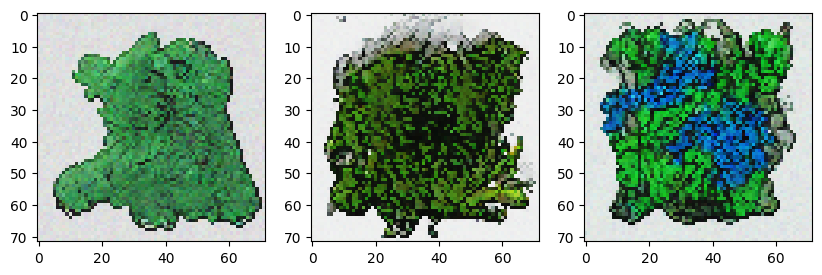

0.01588790:  81%|████████  | 80998/100001 [57:55<12:47, 24.76it/s]  

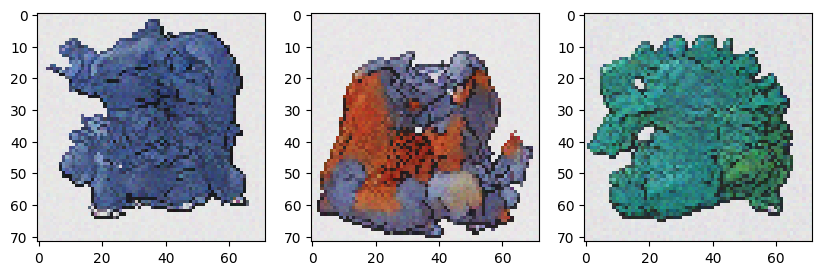

0.01753637:  82%|████████▏ | 82000/100001 [58:38<12:08, 24.70it/s]  

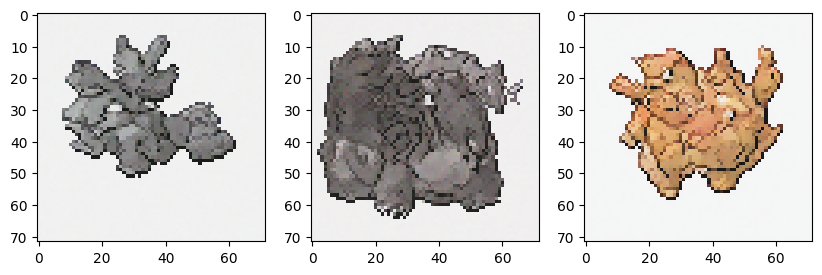

0.01389154:  83%|████████▎ | 82999/100001 [59:21<11:28, 24.68it/s]  

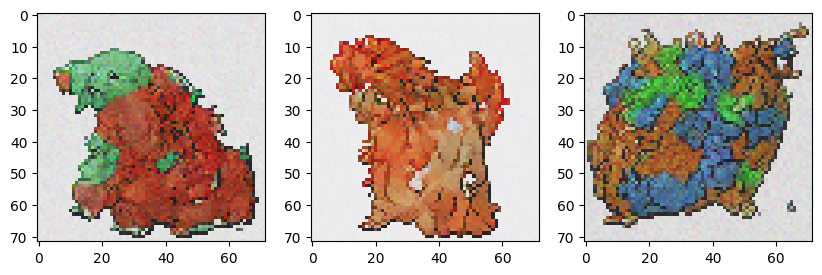

0.01218154:  84%|████████▍ | 83998/100001 [1:00:04<10:47, 24.70it/s]

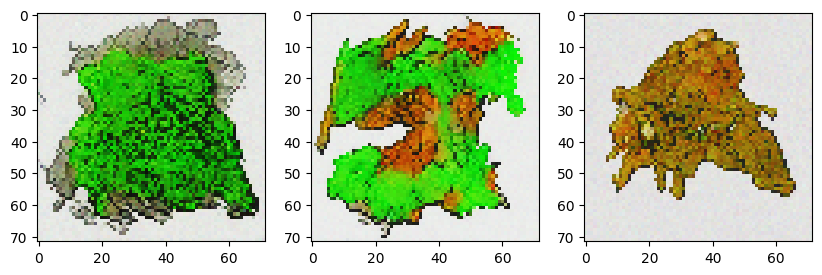

0.01554654:  85%|████████▍ | 85000/100001 [1:00:47<10:06, 24.72it/s]  

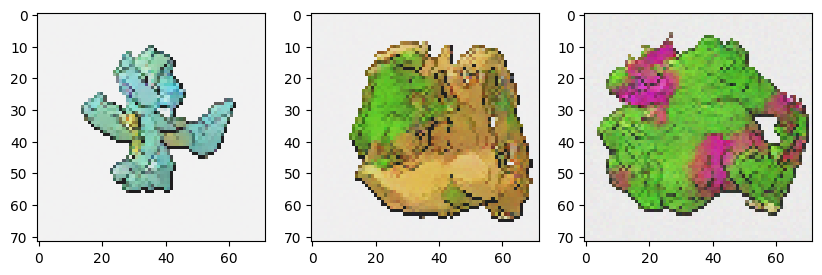

0.01948394:  86%|████████▌ | 85999/100001 [1:01:30<09:27, 24.68it/s]  

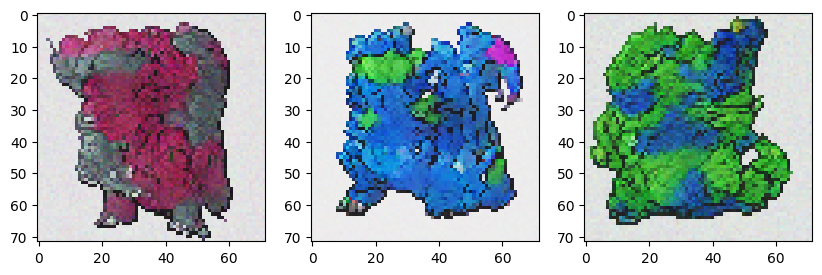

0.02061381:  87%|████████▋ | 86998/100001 [1:02:13<08:45, 24.74it/s]  

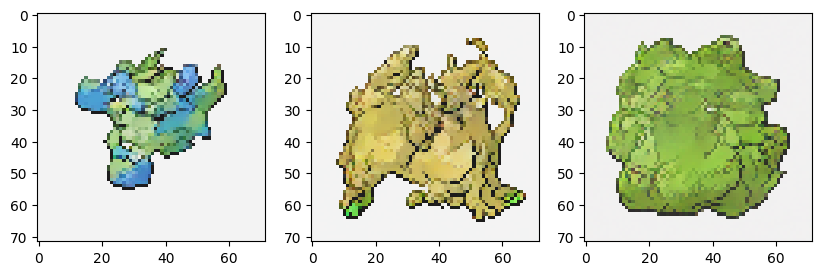

0.01433489:  88%|████████▊ | 88000/100001 [1:02:56<08:05, 24.71it/s]  

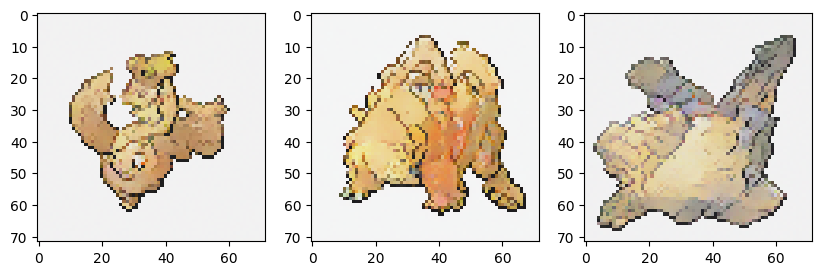

0.01715904:  89%|████████▉ | 88999/100001 [1:03:38<07:24, 24.76it/s]

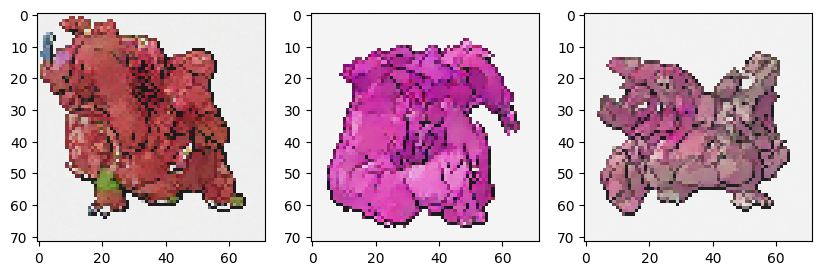

0.01756269:  90%|████████▉ | 89998/100001 [1:04:21<06:45, 24.68it/s]

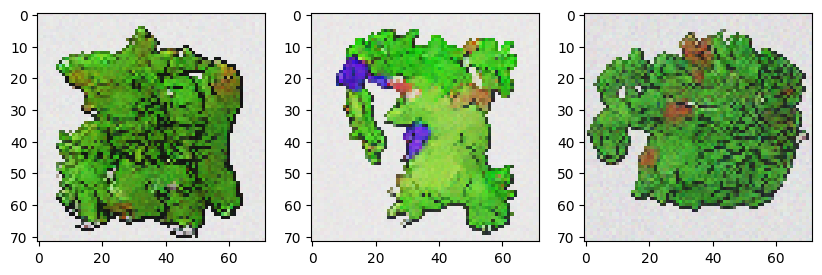

0.01228814:  91%|█████████ | 91000/100001 [1:05:04<06:03, 24.74it/s]

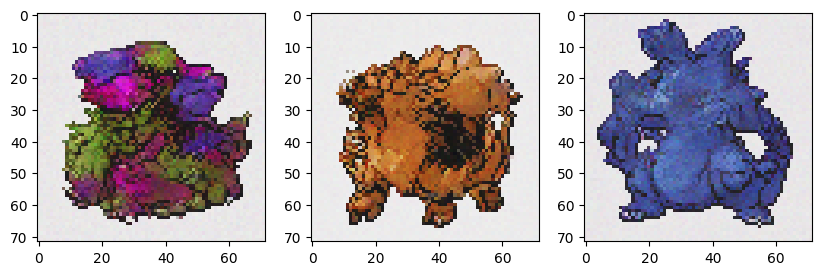

0.01687238:  92%|█████████▏| 91999/100001 [1:05:47<05:24, 24.68it/s]

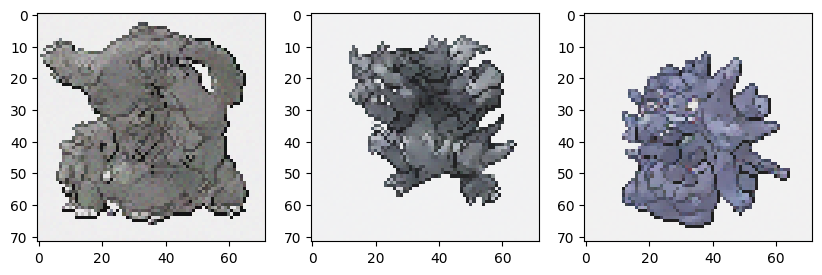

0.01186941:  93%|█████████▎| 92998/100001 [1:06:30<04:42, 24.75it/s]

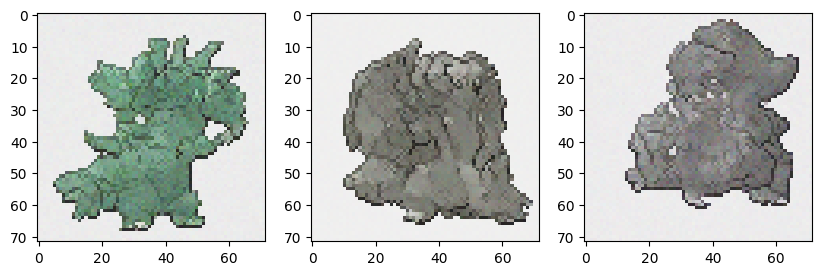

0.01946942:  94%|█████████▍| 94000/100001 [1:07:13<04:02, 24.72it/s]

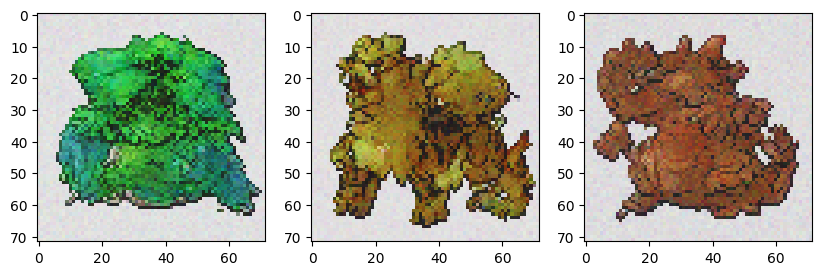

0.02768263:  95%|█████████▍| 94999/100001 [1:07:56<03:22, 24.71it/s]

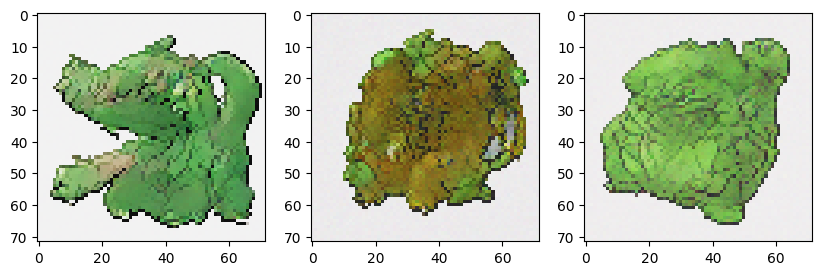

0.01973158:  96%|█████████▌| 95998/100001 [1:08:39<02:42, 24.70it/s]

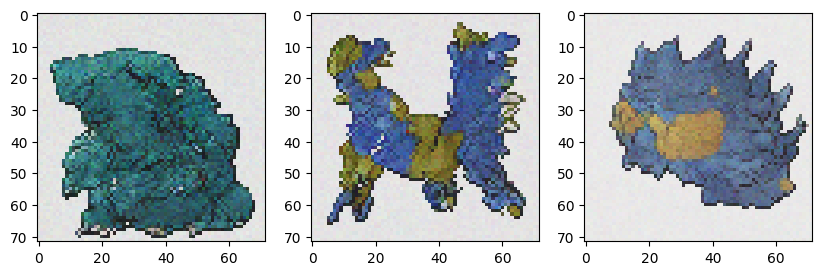

0.02064319:  97%|█████████▋| 97000/100001 [1:09:22<02:01, 24.69it/s]

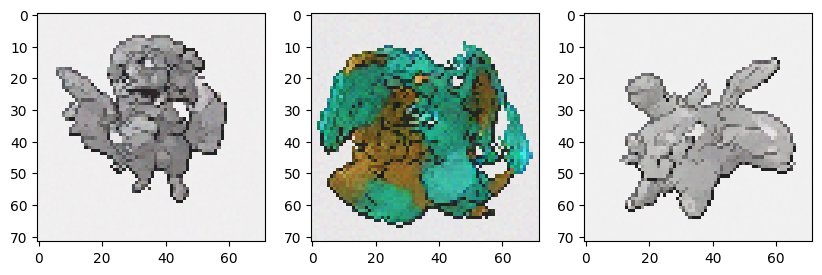

0.01613200:  98%|█████████▊| 97999/100001 [1:10:05<01:21, 24.70it/s]

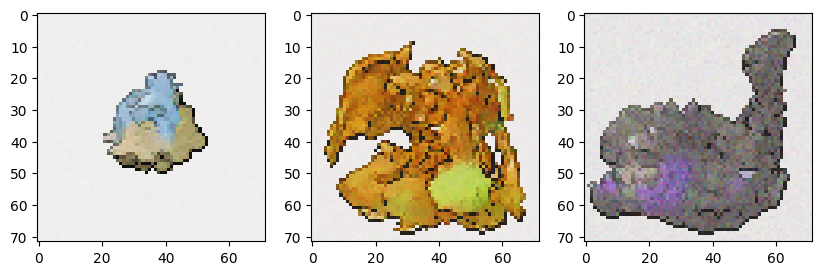

0.01759948:  99%|█████████▉| 98998/100001 [1:10:48<00:41, 24.27it/s]

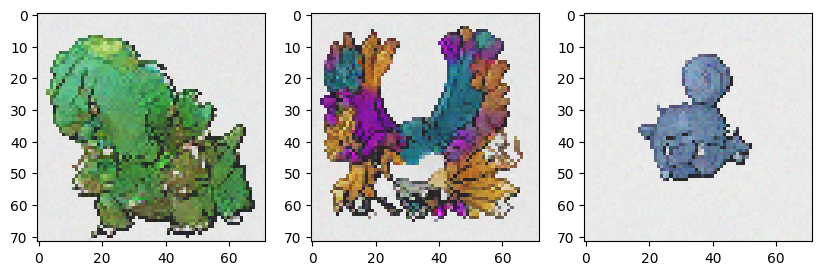

0.01353635: 100%|█████████▉| 100000/100001 [1:11:31<00:00, 24.64it/s]

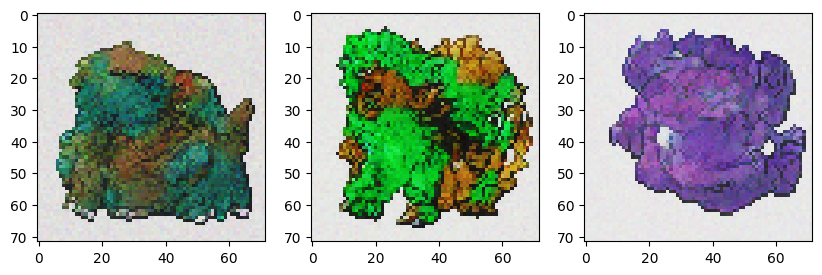

0.01392876: 100%|██████████| 100001/100001 [1:11:33<00:00, 23.29it/s]


In [8]:
model = UNet(3, 3, time_dim=256, num_classes=len(all_types) + 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

loss_func = nn.MSELoss()

pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 16

    source = torch.randint(0, 2, (bs,))
    batch = torch.randperm(385)[:bs]
    
    x0 = pimages[source, batch]
    c = contour[source, batch]

    xc = torch.cat([x0, c], dim=1)
    xc = torch.stack([pos_transform(x) for x in xc], dim=0)
    
    x0 = xc[:, :-1]
    c = xc[:, [-1]]

    x0 = torch.stack([col_transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty, c)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')